<a href="https://colab.research.google.com/github/YoshiCity96/ML/blob/main/ML2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Размер выборки для кластеризации: (10000, 14)


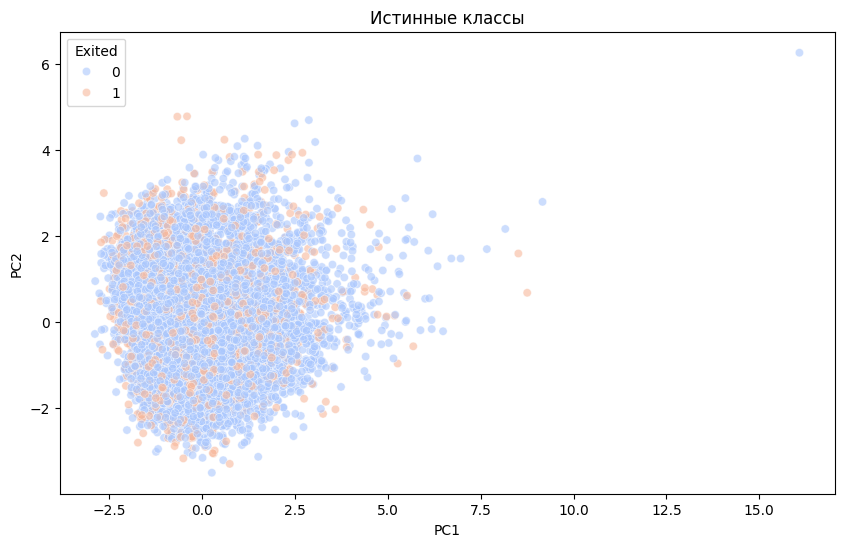

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.utils import resample


try:
    df = pd.read_csv('Churn.csv')
except FileNotFoundError:
    print("Ошибка: Загрузи файл Churn.csv!")

# Переименование и удаление лишнего
if 'churn' in df.columns:
    df.rename(columns={'churn': 'Exited'}, inplace=True)
df_clean = df.drop(['RowNumber', 'CustomerId', 'Surname', 'id', 'ID'], axis=1, errors='ignore')

# Кодирование
cat_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)
else:
    df_encoded = df_clean.copy()

# Заполнение пропусков
X_full = df_encoded.drop('Exited', axis=1)
y_full = df_encoded['Exited']

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_full)

# Нормализация
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X_imputed)


X_sample, y_sample = resample(X_scaled_full, y_full, n_samples=10000, random_state=42, replace=False)

print(f"Размер выборки для кластеризации: {X_sample.shape}")

# --- PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

# Визуализируем метки
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_sample, palette='coolwarm', alpha=0.6)
plt.title('Истинные классы')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


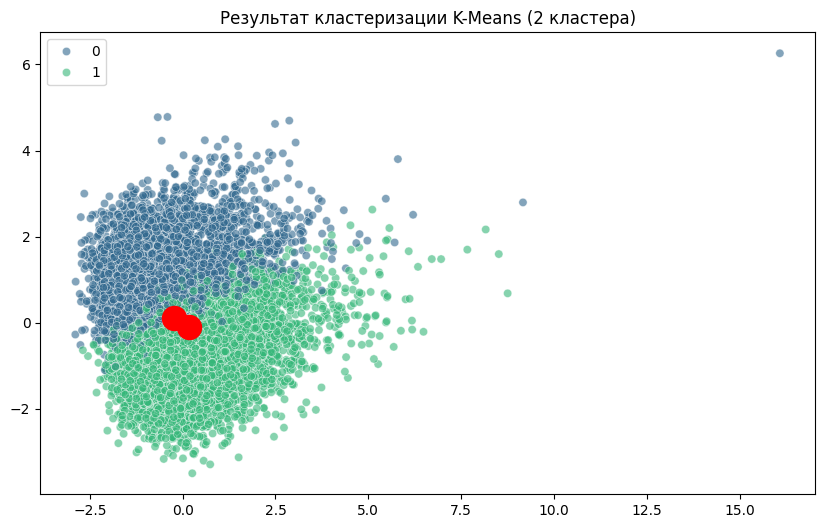

K-Means ARI Score: -0.0041

Сравнение меток (строки - истина, столбцы - кластер):
Cluster     0     1
True               
0        3271  4961
1         657  1111


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, classification_report

# Запускаем K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_sample)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_kmeans, palette='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('Результат кластеризации K-Means (2 кластера)')
plt.show()


score_kmeans = adjusted_rand_score(y_sample, clusters_kmeans)
print(f"K-Means ARI Score: {score_kmeans:.4f}")

# Таблица сопряженности
print("\nСравнение меток (строки - истина, столбцы - кластер):")
print(pd.crosstab(y_sample, clusters_kmeans, rownames=['True'], colnames=['Cluster']))

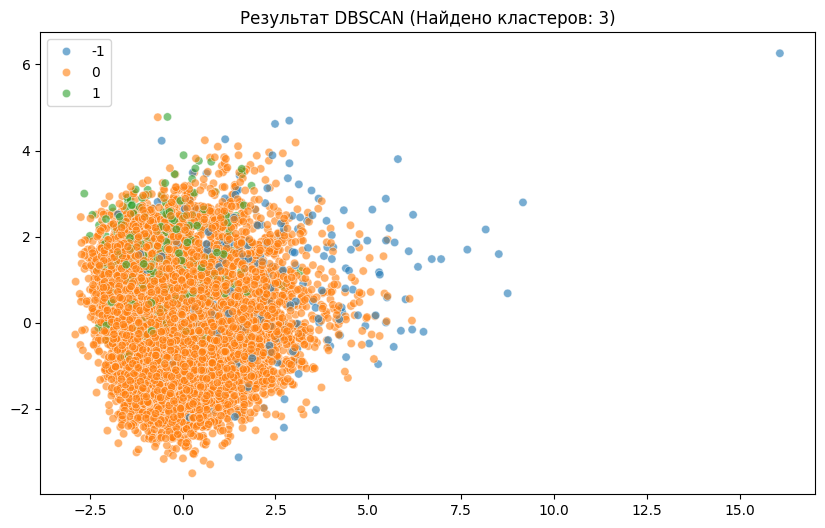

DBSCAN ARI Score: 0.0238

Сравнение меток:
Cluster   -1     0    1
True                   
0        187  7746  299
1         74  1622   72


In [7]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=3.0, min_samples=10)
clusters_dbscan = dbscan.fit_predict(X_sample)


plt.figure(figsize=(10, 6))
# Кластер -1 это шум
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_dbscan, palette='tab10', alpha=0.6)
plt.title(f'Результат DBSCAN (Найдено кластеров: {len(np.unique(clusters_dbscan))})')
plt.show()

score_dbscan = adjusted_rand_score(y_sample, clusters_dbscan)
print(f"DBSCAN ARI Score: {score_dbscan:.4f}")
print("\nСравнение меток:")
print(pd.crosstab(y_sample, clusters_dbscan, rownames=['True'], colnames=['Cluster']))

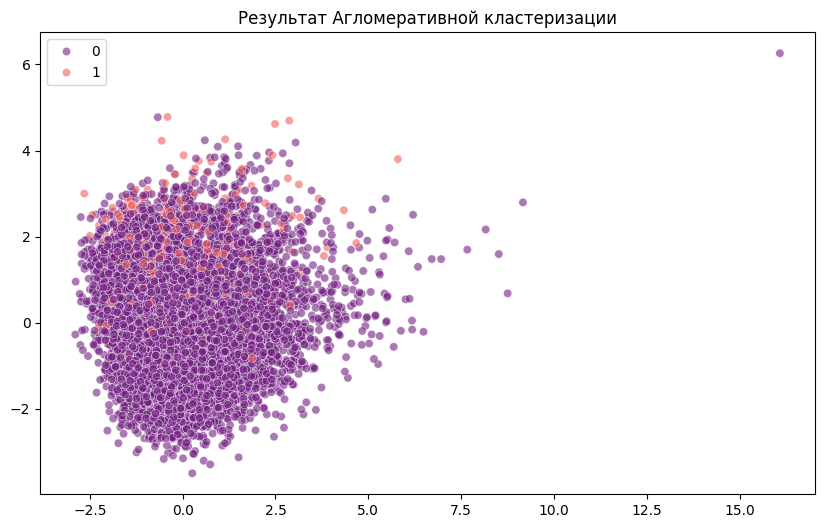

Agglomerative ARI Score: 0.0174

Сравнение меток:
Cluster     0    1
True              
0        7875  357
1        1662  106


In [8]:
from sklearn.cluster import AgglomerativeClustering


agg = AgglomerativeClustering(n_clusters=2)
clusters_agg = agg.fit_predict(X_sample)


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_agg, palette='magma', alpha=0.6)
plt.title('Результат Агломеративной кластеризации')
plt.show()

score_agg = adjusted_rand_score(y_sample, clusters_agg)
print(f"Agglomerative ARI Score: {score_agg:.4f}")
print("\nСравнение меток:")
print(pd.crosstab(y_sample, clusters_agg, rownames=['True'], colnames=['Cluster']))

Выводы по этапу кластеризации:
1. Визуализация (PCA):
График PCA показал, что объекты двух классов (Exited=0 и Exited=1) в признаковом пространстве не образуют раздельных групп. Они смешаны в одно плотное облако. Это заранее говорит о том, что методы геометрической кластеризации будут работать плохо.
2. Результаты алгоритмов:

 K-Means: Алгоритм разделил облако данных на две части, но это деление оказалось случайным относительно целевой переменной. Метрика ARI Score = -0.0041 подтверждает, что полученные кластеры не имеют ничего общего с реальными метками оттока. Таблица сопряженности показывает, что в обоих кластерах смешаны и ушедшие, и оставшиеся клиенты.

 DBSCAN: Алгоритм выделил один гигантский кластер (Cluster 0), в который попало большинство точек обоих классов (7746 "оставшихся" и 1622 "ушедших"). Это подтверждает отсутствие зон разряжения (пустот) между классами. ARI Score = 0.0238 также указывает на отсутствие связи с целевой меткой.

 3Агломеративная кластеризация: Показала результат, схожий с K-Means (ARI Score = 0.0174). Она также просто геометрически "разрезала" облако данных, не выявив смысловой структуры.

3. Сравнение с обучением с учителем:
Ранее методы обучения с учителем (Random Forest) давали Accuracy > 80%. Это возможно, потому что Random Forest строит сложные границы решений, опираясь на конкретные значения признаков.
Кластеризация же опирается на "расстояние" и "плотность", и для данной задачи эти метрики оказались бесполезны.
Итог: Задача прогнозирования оттока для данного набора данных не решается методами кластеризации. Клиенты, которые уходят из банка, не группируются в отдельный геометрический кластер, а "растворены" среди остальных клиентов. Для этой задачи применимы только методы обучения с учителем.